# Optimization Methods

We are looking to find a good method to automatically find good symbolic defaults. In this notebook, we look at variations of the following optimization methods:

 - $\mu + \lambda$: $\mu$ is the size of the parent population, $\lambda$ is the number of offspring, no new random individuals introduced. For this notebook, NSGA-II selection is used to select $\mu$ parents. NSGA-II selects parents based on multiple objectives along the pareto-front. In our case we try to maximize performance while minimizing symbolic expression length.
 - $1 + \lambda$: a parent population of one, $\lambda$ number of offspring, $\lambda$ new individuals generated each generation. The parent is selected based on performance, with no regard for its expression length.
 - Random Search (soon™): Just evaluate random individuals.
 
For the evolutionary methods, we also consider two (additional) ways to regulate overfitting/expression length:
 
  - Evaluate each individual on a random selection of (surrogate models of) tasks each generation. The goal is to prevent overfitting to the combined surface model of surrogate models.
  - Explicitly restrict the number of operations a symbolic expression can contain (note: the current version has a bug where the constraint can be violated with cross-over).

The following operators were considered:
 - unary: `expit, neg`
 - binary: `add, sub, mul, div, pow, max, min`

Additionaly the '`if_gt`' quaternary operator is considered, which performs the following operations: `if_gt(a,b,c,d): if (a > b) then c else d`.
 
The following inputs were considered:
 - m: number of classes
 - p: number of features
 - n: number of instances
 - mkd: median kernel distance (todo: add link)
 - mcp: majority class ratio (`majority class count / n`)
 - rc: ratio of symbolic features (`number of symbolic features / p`)
 - xvar: variance as calculated on the full data as if it was a single sequence (used in the scikit-learn 0.22 default of SVC).
 - random constants:
     - random choice of {2^i | i int from [-8, .., 8]}
     - random choice of an int in [1, 10]
     - random choice of float in [0, 1]
     
The symbolic defaults were optimized together.

## Comparing Optimization Methods

For comparing the different methods we (currently) use the task of finding symbolic defaults for `C` and `gamma` for the [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) with an rbf-kernel. 
**Note the tiny legend in the top-right corner**

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_result(result, ax):    
    max_score_per_gen = [float(gen.score_max) for gen in result.information_by_generation]
    ax.plot(range(result.n_generations_elapsed), max_score_per_gen)
    ax.set_ylim([0.7, 1.])
    ax.set_xlim([0, 100])
    ax.set_title(result.task)

In [7]:
from visualization.output_parser import parse_eo_console_output
one_plus_lambda = parse_eo_console_output("data/results/rbf_1l_rNone_mNone")
mu_plus_lambda = parse_eo_console_output("data/results/rbf_ml_rNone_mNone")

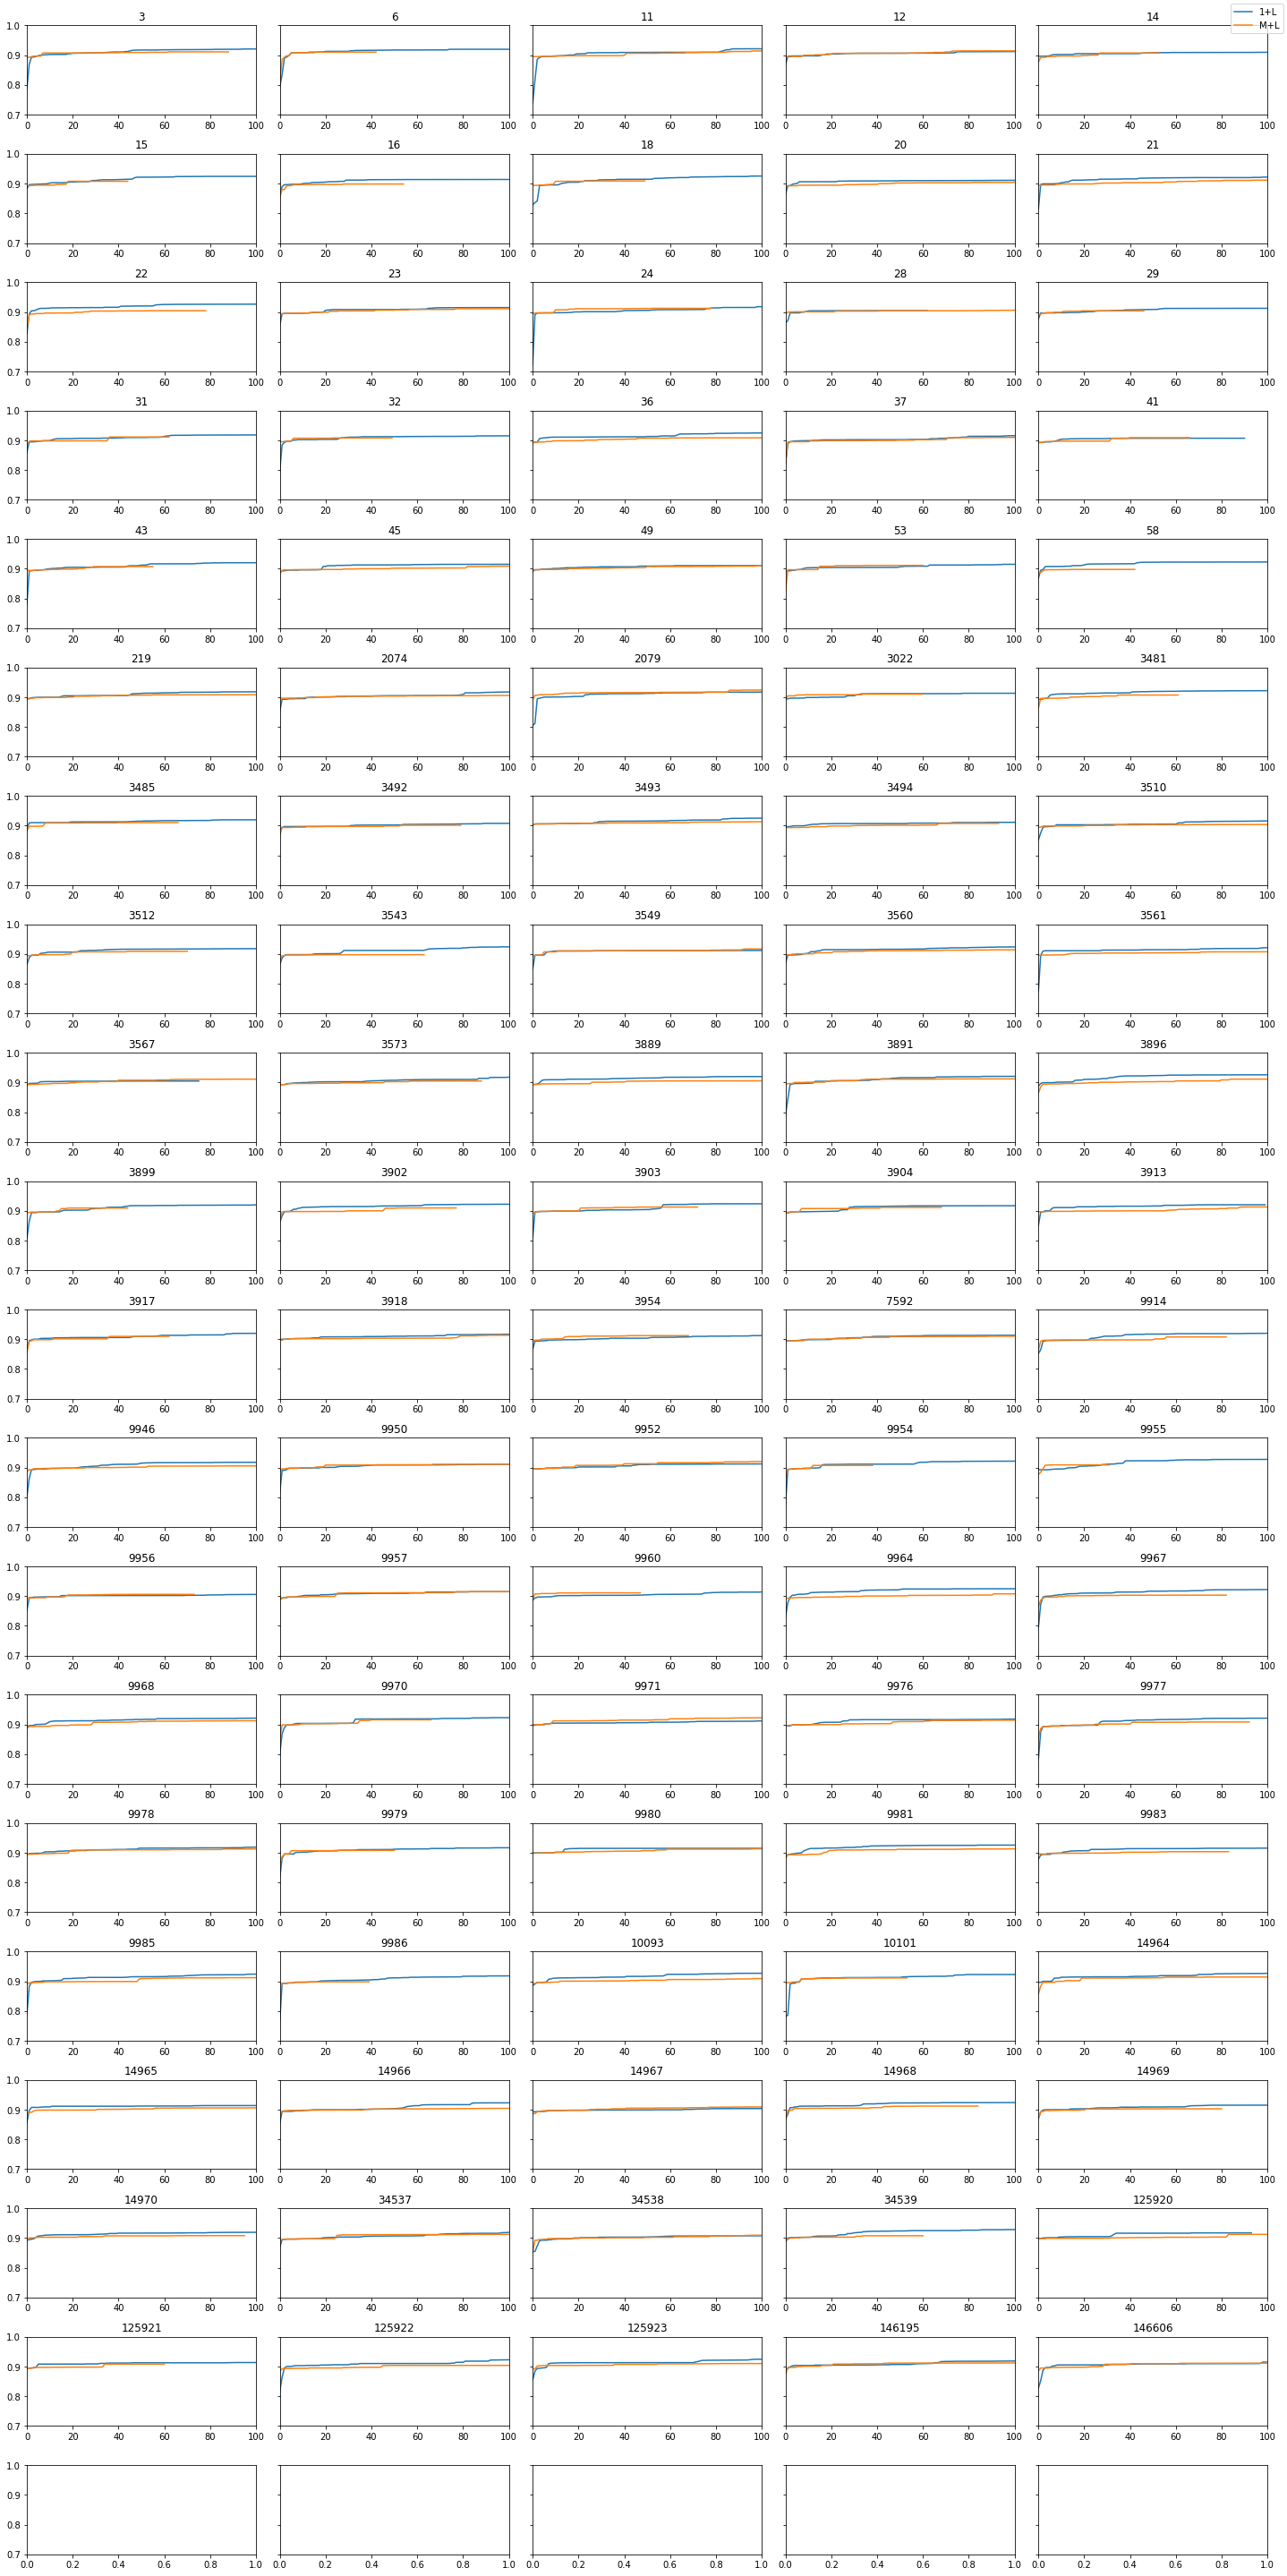

In [12]:
n_rows, n_cols = 20, 5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 40), sharey=True)
for i, (result, result2) in enumerate(zip(one_plus_lambda, mu_plus_lambda)):
    ax = axes[i//n_cols, i % n_cols]
    plot_result(result, ax)
    plot_result(result2, ax)
fig.legend(['1+L','M+L'])
fig.tight_layout()

In [96]:
def plot_length_histograms(methods, method_names, top_n=1):
    lengths_per_method = [[expression.count('(') - 1
                           for task_optimization in method
                           for expression in task_optimization.top_five_expressions[:top_n]]
                          for method in methods]
    maximum_length_across_all = max([length for lengths in lengths_per_method for length in lengths])
    
    fig, ax = plt.subplots()
    ax.set_title('Pipeline length of top {} solutions across all tasks'.format(top_n))
    ax.set_xlabel('Number of operators in expression')
    ax.set_ylabel('Number of occurrences')
    ax.hist(lengths_per_method, bins=range(maximum_length_across_all))
    ax.legend(method_names) 

def plot_score_histograms(methods, method_names):
    scores_per_method = [[float(task_optimization.information_by_generation[-1].score_max)
                          for task_optimization in method]
                         for method in methods]
    
    fig, ax = plt.subplots()
    ax.set_title('Score of best solution for each task')
    ax.set_xlabel('Normalized score')
    ax.set_ylabel('Number of occurrences')
    ax.hist(scores_per_method, bins=np.linspace(0.85,1.0,31))
    ax.legend(method_names)
    
def plot_generations_by_method(methods, method_names):
    ngens_per_method = [[len(task_optimization.information_by_generation)
                         for task_optimization in method]
                        for method in methods]
    
    fig, ax = plt.subplots()
    ax.set_title('Number of generations until stopping for each task')
    ax.set_xlabel('number of generations')
    ax.set_ylabel('Number of occurrences')
    ax.hist(ngens_per_method, bins=range(25, 201, 5))
    ax.legend(method_names)

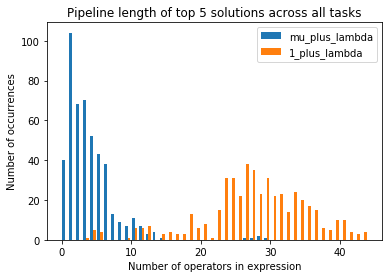

In [56]:
plot_length_histograms([mu_plus_lambda, one_plus_lambda], method_names=['mu_plus_lambda','1_plus_lambda'], top_n=5)

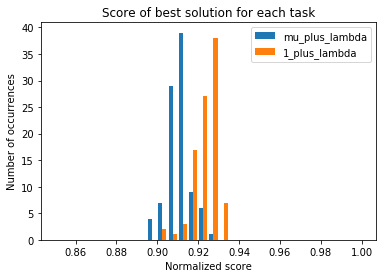

In [69]:
plot_score_histograms([mu_plus_lambda, one_plus_lambda], method_names=['mu_plus_lambda','1_plus_lambda'])

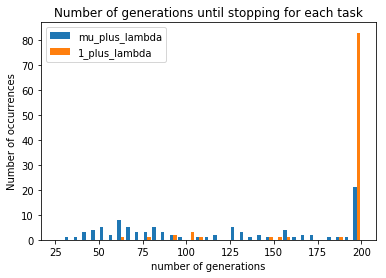

In [97]:
plot_generations_by_method([mu_plus_lambda, one_plus_lambda], method_names=['mu_plus_lambda','1_plus_lambda'])

We see that $\mu + \lambda$ tends to converge to a local optimum pretty early (typically half the budget of $1 + \lambda$). It makes sense that $1 + \lambda$ does not converge as often, as it also has a constant influx of new individuals outside of the local optimum it is currently optimizing towards with the parent. In fact, $\mu + \lambda$ should be restarted multiple times to start from different initial generations.

## Regularization
In the previous section, we could see that without further interference, expressions can get *very* long.
There are two ways I explored to see if we can keep expressions shorter:
 - Using a different subset of tasks to evaluate individuals each generation. The assumption here is that very complicated expressions are overfit to the combined response surface across tasks. By having this response surface vary (by leaving out a different portion of tasks at each evaluation), we hope to reduce this tendency to overfit to a specific response surface. We refer to this method as `subset`.
 - Explicitly disallowing mutation to add components if the expression already has a certain number of operators. In these initial experiments this maximum was set to 3. We refer to this method as `max_depth`.

The effect in $1 + \lambda$ setting:

In [73]:
one_plus_lambda_subset = parse_eo_console_output("data/results/rbf_1l_r9_mNone")
one_plus_lambda_max_depth = parse_eo_console_output("data/results/rbf_1l_rNone_m3")

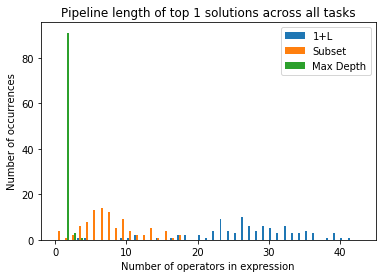

In [74]:
plot_length_histograms([one_plus_lambda, one_plus_lambda_subset, one_plus_lambda_max_depth],
                       ['1+L','Subset', 'Max Depth'])

Of course maximum depth directly affects pipeline length.
However, it is interesting to note that most of the solutions contain one operator, and not the natural maximum of three.

We can also see that the subset method seems to do a reasonable job of regulating pipeline length even without explicit limits on length. I think this likely means our assumption was correct.

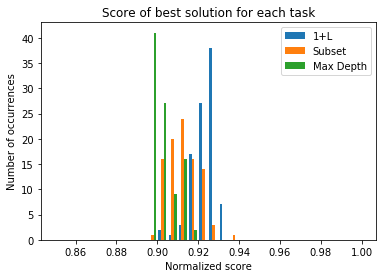

In [78]:
plot_score_histograms([one_plus_lambda, one_plus_lambda_subset, one_plus_lambda_max_depth],
                       ['1+L','Subset', 'Max Depth'])

We should keep in mind that these are scores obtained by averaging the surrogate scores they were optimized for. 
In particular the vanilla version has the (likely) overfit scores.

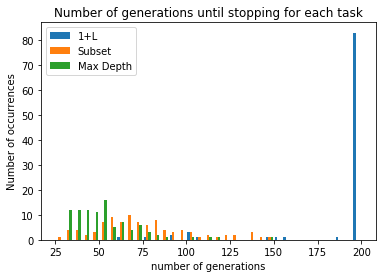

In [98]:
plot_generations_by_method([one_plus_lambda, one_plus_lambda_subset, one_plus_lambda_max_depth],
                       ['1+L','Subset', 'Max Depth'])

The effect in $\mu + \lambda$ setting:

In [84]:
mu_plus_lambda_subset = parse_eo_console_output("data/results/rbf_ml_r9_mNone")
mu_plus_lambda_both = parse_eo_console_output("data/results/rbf_ml_r9_m3")

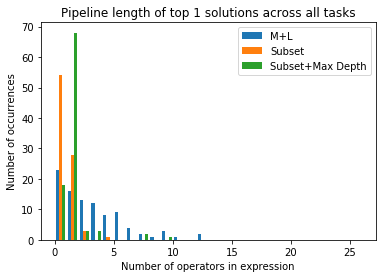

In [88]:
plot_length_histograms([mu_plus_lambda, mu_plus_lambda_subset, mu_plus_lambda_both],
                       ['M+L','Subset', 'Subset+Max Depth'], top_n=1)

First off, note that max depth constrained method still obtained a length greater than 3. This is because the restriction is applied during mutation, not cross-over.

Here we notice something odd: using the subset method by itself leads to smaller pipelines than using it combined with an explicit maximum on pipeline length. Two figures down we also see that this method tends to stop earlier than `subset + max_depth`, which might explain this behavior the following way: because less generation elapse there is (1) less time to grow expressions and (2) less time to optimize expressions with more operators. In think reason (2) is might in particular be a reason we see this trend.

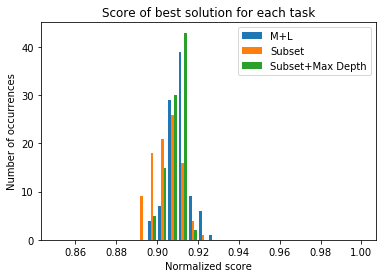

In [86]:
plot_score_histograms([mu_plus_lambda, mu_plus_lambda_subset, mu_plus_lambda_both],
                       ['M+L','Subset', 'Subset+Max Depth'])

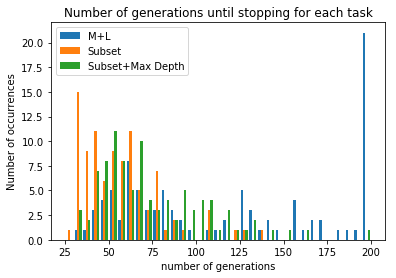

In [99]:
plot_generations_by_method([mu_plus_lambda, mu_plus_lambda_subset, mu_plus_lambda_both],
                           ['M+L','Subset', 'Subset+Max Depth'])

---

# Further Research:

In the regularization section we noticed that $\mu + \lambda$ with just `subset` generated shorter pipelines and stopped earlier than `subset + max_depth`. This prompts us to:
 - rerun the experiment, to see if/how much variance can come into play.
 - adjust the early stopping criteria to adjust for the fact that some subsets will give higher scores on average, and such an evaluation should not lead to an early termination if then that score can not be beaten.
 - $\mu + \lambda$ should be restarted multiple times to start from different initial generations.